<a href="https://colab.research.google.com/github/rckaisen/stock_backtrader/blob/main/stock_backtesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stock Backtrading Simulation**

In [ ]:
!pip install backtrader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 7.7 MB/s eta 0:00:00


In [ ]:
from __future__ import (absolute_import, division, print_function, unicode_literals)

import argparse

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt
import backtrader.indicators as btind
import backtrader.feeds as btfeeds

from backtrader.feeds import GenericCSVData

import pandas
import matplotlib.pyplot as plt

In [ ]:
##############################
# Generic CSV DataFeed Classes
##############################
class GenericCSV(GenericCSVData):
    lines = ('RSI_5day_vs_prevday','smaDiff_5_14','prevclose_price_trend','nextclose_price_trend',)

    params = (
        ('nullvalue', float('NaN')),
        ('dtformat', '%Y-%m-%d'),
        ('datetime', 0),
        ('time', -1),
        ('open', 1),
        ('high', 2),
        ('low', 3),
        ('close', 4),
        ('volume', 6),
        ('openinterest', -1),
        ('RSI_5day_vs_prevday', 7),
        ('smaDiff_5_14', 8),
        ('prevclose_price_trend', 9),
        ('nextclose_price_trend', 10),
    )


In [ ]:
#################
# Helper Classes
#################
class Queue:
    #Constructor creates a list
    def __init__(self):
        self.queue = list()

    #Adding elements to queue
    def enqueue(self,data):
        #Checking to avoid duplicate entry (not mandatory)
        if data not in self.queue:
            self.queue.insert(0,data)
            return True
        return False

    #Removing the last element from the queue
    def dequeue(self):
        if len(self.queue)>0:
            return self.queue.pop()
        return ("Queue Empty!")

    #Getting the size of the queue
    def size(self):
        return len(self.queue)

    #printing the elements of the queue
    def printQueue(self):
        return self.queue

    #Get the first element
    def getElement(self):
        if len(self.queue)>0:
            return self.queue[0]


In [ ]:
########################
# Customized Indicators
########################

# Indicator of past consecutive days up or down trend of close price
class past_consecutive_days_close_price_trend(bt.Indicator):
    lines = ('pastClosePriceTrend',)

    params = (
        ('numOfDays', 3),
        ('period', 5),
    )

    def __init__(self):
        self.sma = btind.SimpleMovingAverage(self.data, period=self.p.period)

    def next(self):
        if ((self.sma[-1] > self.data[-1]) and (self.sma[-2] > self.data[-2]) and (self.sma[-3] > self.data[-3])):
            self.lines.pastClosePriceTrend[0] = -1
        elif ((self.sma[-1] < self.data[-1]) and (self.sma[-2] < self.data[-2]) and (self.sma[-3] < self.data[-3])):
            self.lines.pastClosePriceTrend[0] = 1
        else:
            self.lines.pastClosePriceTrend[0] = 0


In [ ]:
##########################################
# Startegy #1:
# Buy if RSI14 > 70; Sell if RESI14 < 30
##########################################
class strategy_001(bt.Strategy):
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.rsi = btind.RSI_Safe(self.data.close, period=14)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        if not self.position:
            if self.rsi < 30:
                self.buy(size=1)

        else:
            if self.rsi > 70:
                self.sell(size=1)


In [ ]:
####################################################################################################
# Startegy #2:
# Buy if past 3-day close in up trend
# Sell if past 3-day close in down trend
####################################################################################################
class strategy_002(bt.Strategy):
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.indicator_1 = past_consecutive_days_close_price_trend(self.data.close)
        self.sellQueue = Queue()

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        if not self.position:
            if self.indicator_1 == 1:
                self.sellQueue.enqueue(self.datas[0].datetime.date(3))
                self.log(self.sellQueue.size())
                self.log(self.sellQueue.getElement())
                self.buy(size=1)

        else:
            if (self.datas[0].datetime.date(0) == self.sellQueue.getElement()):
                self.sell(size=1)
                self.log(self.sellQueue.dequeue())
                self.log(self.sellQueue.size())

In [ ]:
####################################################################################################
# Startegy #3:
# Buy based on association rules for nextclose_up_trend
# Sell after 3 days
####################################################################################################
class strategy_003(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataopen = self.datas[0].open
        self.datahigh = self.datas[0].high
        self.datalow = self.datas[0].low
        self.dataclose = self.datas[0].close
        self.RSI_5day_vs_prevday = self.datas[0].RSI_5day_vs_prevday
        self.smaDiff_5_14 = self.datas[0].smaDiff_5_14
        self.prevclose_price_trend = self.datas[0].prevclose_price_trend

        # Create a queue to keep track the sell date
        self.sellQueue = Queue()
        self.sellDate = 3
        self.buySize = 10

        # To keep track of pending orders
        self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def next(self):
        # Simply log the closing price of the series from the reference
        #self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Simply log the closing price of the series from the reference
        #self.log('Open, %.2f' % self.dataopen[0])
        #self.log('High, %.2f' % self.datahigh[0])
        #self.log('Low, %.2f' % self.datalow[0])
        #self.log('Close, %.2f' % self.dataclose[0])
        #self.log('RSI_5day_vs_prevday, %.2f' % self.RSI_5day_vs_prevday[0])
        #self.log('smaDiff_5_14, %.2f' % self.smaDiff_5_14[0])
        #self.log('prevclose_price_trend, %.2f' % self.prevclose_price_trend[0])
        #self.log('RSI, %.2f' % self.rsi[0])

        #################################
        #---------- Reference ----------#
        #################################

        # for RSI_5day_vs_prevday:
        # "noChange_below30" = 1
        # "noChange_btw30and70" = 2
        # "noChange_above70" = 3
        # "below30_to_btw30and70" = 4
        # "btw30and70_to_above70" =  5
        # "above70_to_btw30and70" = 6
        # "btw30and70_to_below30" = 7
        # "below30_to_above70" = 8
        # "above70_to_below30" = 9

        # for smaDiff_5_14:
        # sma5_above_sma14 = 1
        # sma5_cross_below_sma14 = 2
        # sma5_cross_above_sma14 = 3
        # sma5_below_sma14 = 4

        # for prevclose_price_trend:
        # prevclose_na = 0
        # prevclose_up_trend = 1
        # prevclose_down_trend = 2

        #################################
        #---------- Reference ----------#
        #################################

        if not self.position:
            if self.RSI_5day_vs_prevday[0] == 4 and self.smaDiff_5_14[0] == 1:
                self.buy(size=self.buySize)
                self.sellQueue.enqueue(self.datas[0].datetime.date(self.sellDate))
            elif self.RSI_5day_vs_prevday[0] == 4 and self.smaDiff_5_14[0] == 3:
                self.buy(size=self.buySize)
                self.sellQueue.enqueue(self.datas[0].datetime.date(self.sellDate))
            elif self.RSI_5day_vs_prevday[0] == 1 and self.smaDiff_5_14[0] == 1:
                self.buy(size=self.buySize)
                self.sellQueue.enqueue(self.datas[0].datetime.date(self.sellDate))
            elif self.RSI_5day_vs_prevday[0] == 1 and self.smaDiff_5_14[0] == 3:
                self.buy(size=self.buySize)
                self.sellQueue.enqueue(self.datas[0].datetime.date(self.sellDate))
            elif self.RSI_5day_vs_prevday[0] == 7 and self.prevclose_price_trend[0] == 1:
                self.buy(size=self.buySize)
                self.sellQueue.enqueue(self.datas[0].datetime.date(self.sellDate))
            elif self.RSI_5day_vs_prevday[0] == 7 and self.smaDiff_5_14[0] == 3 and self.prevclose_price_trend[0] == 2:
                self.buy(size=self.buySize)
                self.sellQueue.enqueue(self.datas[0].datetime.date(self.sellDate))

        else:
            if (self.datas[0].datetime.date(0) == self.sellQueue.getElement()):
                self.sell(size=self.buySize)
                self.sellQueue.dequeue()

In [ ]:
####################################################################################################
# Startegy #4:
# Buy based on association rules for nextclose_up_trend
# Sell based on association rules for nextclose_down_trend
####################################################################################################
class strategy_004(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataopen = self.datas[0].open
        self.datahigh = self.datas[0].high
        self.datalow = self.datas[0].low
        self.dataclose = self.datas[0].close
        self.RSI_5day_vs_prevday = self.datas[0].RSI_5day_vs_prevday
        self.smaDiff_5_14 = self.datas[0].smaDiff_5_14
        self.prevclose_price_trend = self.datas[0].prevclose_price_trend

        self.buySize = 10

        # To keep track of pending orders
        self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def next(self):
        # Simply log the closing price of the series from the reference
        #self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Simply log the closing price of the series from the reference
        #self.log('Open, %.2f' % self.dataopen[0])
        #self.log('High, %.2f' % self.datahigh[0])
        #self.log('Low, %.2f' % self.datalow[0])
        #self.log('Close, %.2f' % self.dataclose[0])
        #self.log('RSI_5day_vs_prevday, %.2f' % self.RSI_5day_vs_prevday[0])
        #self.log('smaDiff_5_14, %.2f' % self.smaDiff_5_14[0])
        #self.log('prevclose_price_trend, %.2f' % self.prevclose_price_trend[0])
        #self.log('RSI, %.2f' % self.rsi[0])

        #################################
        #---------- Reference ----------#
        #################################

        # for RSI_5day_vs_prevday:
        # "noChange_below30" = 1
        # "noChange_btw30and70" = 2
        # "noChange_above70" = 3
        # "below30_to_btw30and70" = 4
        # "btw30and70_to_above70" =  5
        # "above70_to_btw30and70" = 6
        # "btw30and70_to_below30" = 7
        # "below30_to_above70" = 8
        # "above70_to_below30" = 9

        # for smaDiff_5_14:
        # sma5_above_sma14 = 1
        # sma5_cross_below_sma14 = 2
        # sma5_cross_above_sma14 = 3
        # sma5_below_sma14 = 4

        # for prevclose_price_trend:
        # prevclose_na = 0
        # prevclose_up_trend = 1
        # prevclose_down_trend = 2

        #################################
        #---------- Reference ----------#
        #################################

        if not self.position:
            if self.RSI_5day_vs_prevday[0] == 4 and self.smaDiff_5_14[0] == 1:
                self.buy(size=self.buySize)
            elif self.RSI_5day_vs_prevday[0] == 4 and self.smaDiff_5_14[0] == 3:
                self.buy(size=self.buySize)
            elif self.RSI_5day_vs_prevday[0] == 1 and self.smaDiff_5_14[0] == 1:
                self.buy(size=self.buySize)
            elif self.RSI_5day_vs_prevday[0] == 1 and self.smaDiff_5_14[0] == 3:
                self.buy(size=self.buySize)
            elif self.RSI_5day_vs_prevday[0] == 7 and self.prevclose_price_trend[0] == 1:
                self.buy(size=self.buySize)
            elif self.RSI_5day_vs_prevday[0] == 7 and self.smaDiff_5_14[0] == 3 and self.prevclose_price_trend[0] == 2:
                self.buy(size=self.buySize)

        else:
            self.sell(size=1)

            if self.RSI_5day_vs_prevday[0] == 2 and self.smaDiff_5_14[0] == 3 and self.prevclose_price_trend[0] == 1:
                self.sell(size=self.buySize)
            elif self.smaDiff_5_14[0] == 3 and self.prevclose_price_trend[0] == 1:
                self.sell(size=self.buySize)
            elif self.RSI_5day_vs_prevday[0] == 6 and self.smaDiff_5_14[0] == 4 and self.prevclose_price_trend[0] == 2:
                self.sell(size=self.buySize)
            elif self.RSI_5day_vs_prevday[0] == 6 and self.smaDiff_5_14[0] == 3 and self.prevclose_price_trend[0] == 2:
                self.sell(size=self.buySize)
            elif self.RSI_5day_vs_prevday[0] == 6 and self.prevclose_price_trend[0] == 1:
                self.sell(size=self.buySize)
            elif self.RSI_5day_vs_prevday[0] == 3 and self.smaDiff_5_14[0] == 3:
                self.sell(size=self.buySize)
            elif self.RSI_5day_vs_prevday[0] == 3 and self.smaDiff_5_14[0] == 3 and self.prevclose_price_trend[0] == 0:
                self.sell(size=self.buySize)
            elif self.RSI_5day_vs_prevday[0] == 3 and self.prevclose_price_trend[0] == 0:
                self.sell(size=self.buySize)
            elif self.RSI_5day_vs_prevday[0] == 6:
                self.sell(size=self.buySize)
            elif self.RSI_5day_vs_prevday[0] == 5 and self.prevclose_price_trend[0] == 2:
                self.sell(size=self.buySize)
            elif self.RSI_5day_vs_prevday[0] == 3 and self.prevclose_price_trend[0] == 1:
                self.sell(size=self.buySize)
            elif self.RSI_5day_vs_prevday[0] == 5 and self.smaDiff_5_14[0] == 4 and self.prevclose_price_trend[0] == 2:
                self.sell(size=self.buySize)
            elif self.RSI_5day_vs_prevday[0] == 6 and self.prevclose_price_trend[0] == 2:
                self.sell(size=self.buySize)
            elif self.RSI_5day_vs_prevday[0] == 3:
                self.sell(size=self.buySize)
            elif self.RSI_5day_vs_prevday[0] == 6 and self.smaDiff_5_14[0] == 3 and self.prevclose_price_trend[0] == 0:
                self.sell(size=self.buySize)
            elif self.RSI_5day_vs_prevday[0] == 6 and self.smaDiff_5_14[0] == 4:
                self.sell(size=self.buySize)
            elif self.RSI_5day_vs_prevday[0] == 6 and self.smaDiff_5_14[0] == 3:
                self.sell(size=self.buySize)


In [ ]:
####################################################################################################
# Startegy #5:
####################################################################################################
class strategy_005(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataopen = self.datas[0].open
        self.datahigh = self.datas[0].high
        self.datalow = self.datas[0].low
        self.dataclose = self.datas[0].close
        self.datavolume = self.datas[0].volume

        self.smaClose10 = btind.SimpleMovingAverage(self.datas[0].close, period=10)
        #self.smaClose20 = bt.talib.SMA(self.data[0].close, timeperiod=20)
        #self.smaClose50 = bt.talib.SMA(self.data[0].close, timeperiod=50)
        #self.smaClose100 = bt.talib.SMA(self.data[0].close, timeperiod=100)

        # To keep track of pending orders
        self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def next(self):
        self.log('Open: %.2f' % self.dataopen[0])
        self.log('Close: %.2f' % self.dataclose[0])
        self.log('Low: %.2f' % self.datalow[0])
        self.log('High: %.2f' % self.datahigh[0])
        self.log('Volume: %d' % self.datavolume[0])

        self.log('SMA Close 10: %d' % self.smaClose10[0])
        #self.log('SMA Close 20: %d' % self.smaClose20[0])
        #self.log('SMA Close 50: %d' % self.smaClose50[0])
        #self.log('SMA Close 100: %d' % self.smaClose100[0])

        if not self.position:
            pass

        else:
            pass

In [ ]:
###################
# Helper functions
###################

# parsing date
def parser(x):
    return pandas.datetime.strptime(x,'%Y-%m-%d')

def parse_args():
    parser = argparse.ArgumentParser(description='stock_backtesting')

    parser.add_argument('--noheaders', action='store_true', default=False,
                        required=False,
                        help='Do not use header rows')

    parser.add_argument('--noprint', action='store_true', default=False,
                        help='Print the dataframe')

    return parser.parse_args()

In [ ]:
###############
# Main Program
###############
#if __name__ == '__main__':
#    args = parse_args()

# Create a cerebro entity
cerebro = bt.Cerebro()

# Add a strategy
cerebro.addstrategy(strategy_001)

# Get a pandas dataframe
#modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
#datapath = os.path.join(modpath, 'data/HSI.csv')
datapath = 'data/HSI.csv'

# Simulate the header row isn't there if noheaders requested
#skiprows = 1 if args.noheaders else 0
#header = None if args.noheaders else 0
skiprows = 0
header = 0

dataframe = pandas.read_csv(datapath,
                                skiprows=skiprows,
                                header=header,
                                parse_dates=True,
                                date_parser=parser,
                                index_col=0)
dataframe = dataframe.dropna()
dataframe = dataframe.round({'Open': 3, 'High': 3, 'Low': 3, 'Close': 3})

# start from 2001-07-09 as no volume before this date

#-- for debug
#if not args.noprint:
print('--------------------------------------------------')
print(dataframe)
print('--------------------------------------------------')

# Pass it to the backtrader datafeed and add it to the cerebro
data = btfeeds.PandasData(dataname=dataframe,
                         fromdate=datetime.datetime(2001, 7, 9),
                         todate=datetime.datetime(2019, 2, 15))

# Add the Data Feed to Cerebro
cerebro.adddata(data)

# Set our desired cash start
cerebro.broker.setcash(1000000.0)

# Add a FixedSize sizer according to the stake
cerebro.addsizer(bt.sizers.FixedSize, stake=10)

# Set the commission
cerebro.broker.setcommission(commission=0.005)

# Print out the starting conditions
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Plot the result
cerebro.plot()

<ipython-input-88-56c3a617d1af>:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  return pandas.datetime.strptime(x,'%Y-%m-%d')


--------------------------------------------------
                 Open       High        Low      Close     Adj Close  \
Date                                                                   
1986-12-31   2568.300   2568.300   2568.300   2568.300   2568.300049   
1987-01-02   2540.100   2540.100   2540.100   2540.100   2540.100098   
1987-01-05   2552.400   2552.400   2552.400   2552.400   2552.399902   
1987-01-06   2583.900   2583.900   2583.900   2583.900   2583.899902   
1987-01-07   2607.100   2607.100   2607.100   2607.100   2607.100098   
...               ...        ...        ...        ...           ...   
2019-02-11  27927.449  28143.840  27847.850  28143.840  28143.839844   
2019-02-12  28093.311  28219.590  27983.480  28171.330  28171.330078   
2019-02-13  28184.869  28533.359  28160.461  28497.590  28497.589844   
2019-02-14  28396.400  28476.650  28275.180  28432.051  28432.050781   
2019-02-15  28241.439  28256.689  27845.869  27900.840  27900.839844   

            

<IPython.core.display.Javascript object>

[[<Figure size 640x480 with 5 Axes>]]

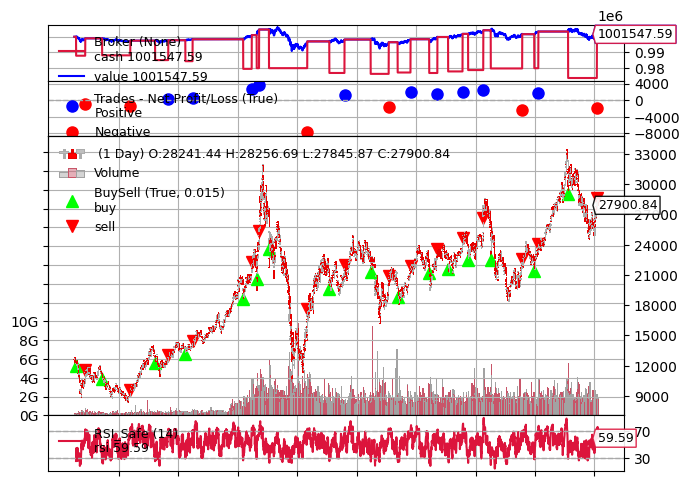

In [ ]:
%matplotlib inline
plt.show()